In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize

## 우선 기존 데이터에서 real_time ratio를 구해보면서 전체 1이 나오는지 확인할 것

In [15]:
data=pd.read_csv("../levelups_panel_20240717.csv", encoding="utf-8")
data = data[data['level_to'] <= 100]
data = data[data['highest_level'] >= 100]
data['binge'] = (data['first_session_level'] >= 50).astype(int)

In [16]:
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 interval의 누적합을 계산하여 'interval_until' 컬럼에 저장
data['interval_until'] = data.groupby('player_slug')['interval'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
data['interval_tot'] = data.groupby('player_slug')['interval_until'].transform('last')

##정규화 된 값 저장
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 level_to가 동일한 값들끼리 interval을 정규화
# level_to가 동일한 값들끼리 interval 값을 정규화
data['interval_normalized'] = data.groupby('level_to')['interval'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1
)
# 정규화된 interval 값을 기반으로 누적합을 계산하여 'interval_until' 컬럼에 저장
data['interval_until_norm'] = data.groupby('player_slug')['interval_normalized'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
data['interval_tot_norm'] = data.groupby('player_slug')['interval_until_norm'].transform('last')


In [17]:
# 'date_event' 컬럼을 datetime 형식으로 변환 (ISO 8601 형식 처리)
data['real_datetime'] = pd.to_datetime(data['event_datetime'])

# player_slug별로 첫 번째와 마지막 event_datetime을 구함
first_last_event = data.groupby('player_slug')['real_datetime'].agg(['min', 'max'])

# 현실 시간 차이 계산 (마지막 시간 - 처음 시간)
first_last_event['real_time_difference'] = first_last_event['max'] - first_last_event['min']
# 현실 시간 차이를 시간으로 변환
first_last_event['real_time_difference_in_hours'] = first_last_event['real_time_difference'].dt.total_seconds() / 3600
# player_slug를 기준으로 병합
data = data.merge(first_last_event[['real_time_difference_in_hours']], on='player_slug', how='left')

# 결과 확인
print(data[['player_slug', 'real_time_difference_in_hours']])
data_last= data.drop_duplicates(subset='player_slug', keep='last')

                     player_slug  real_time_difference_in_hours
0       2021-11-01T08:32:01.518Z                      22.534722
1       2021-11-01T08:32:01.518Z                      22.534722
2       2021-11-01T08:32:01.518Z                      22.534722
3       2021-11-01T08:32:01.518Z                      22.534722
4       2021-11-01T08:32:01.518Z                      22.534722
...                          ...                            ...
720616  2022-03-30T06:38:53.434Z                       2.758056
720617  2022-03-30T06:38:53.434Z                       2.758056
720618  2022-03-30T06:38:53.434Z                       2.758056
720619  2022-03-30T06:38:53.434Z                       2.758056
720620  2022-03-30T06:38:53.434Z                       2.758056

[720621 rows x 2 columns]


In [18]:
# 'interval_tot'을 'real_time_difference_in_seconds'로 나눈 값 계산
data_last['interval_to_real_time_ratio'] = data_last['interval_tot'] / (data_last['real_time_difference_in_hours'])
# 결과 확인
print(data_last['interval_to_real_time_ratio'])

98        1.078040
197       1.012989
296       1.003187
395       1.001581
494       1.000261
            ...   
720224    1.004955
720323    1.001255
720422    1.010686
720521    1.002455
720620    1.021855
Name: interval_to_real_time_ratio, Length: 7279, dtype: float64


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_9408\1736520679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_last['interval_to_real_time_ratio'] = data_last['interval_tot'] / (data_last['real_time_difference_in_hours'])


In [40]:
data_last['interval_to_real_time_ratio'].min()

1.0000129061748528

In [30]:
# 'interval_to_real_time_ratio' 컬럼에서 최소값 찾기
min_value = data_last['interval_to_real_time_ratio'].max()

# 최소값에 해당하는 행 찾기
min_value_row = data_last[data_last['interval_to_real_time_ratio'] == min_value]
min_value_row


,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,date_interval,binge,interval_until,interval_tot,interval_normalized,interval_until_norm,interval_tot_norm,real_datetime,real_time_difference_in_hours,interval_to_real_time_ratio


In [37]:
# 최댓값 2개 가져오기
top_2_values = data_last['interval_to_real_time_ratio'].nlargest(5)

# 두 번째 최댓값 가져오기
second_largest_value = top_2_values.iloc[3]

# 해당 값을 가진 행을 찾기
second_largest_row = data_last[data_last['interval_to_real_time_ratio'] == second_largest_value]

second_largest_row

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,date_interval,binge,interval_until,interval_tot,interval_normalized,interval_until_norm,interval_tot_norm,real_datetime,real_time_difference_in_hours,interval_to_real_time_ratio
251756,2021-12-26T00:12:52.261Z,콱씨,1,0,0.0,7.0,100,drop,99,100,...,0.120556,0,785.975278,785.975278,0.000033,1.082888,1.082888,2022-01-29 10:26:50,60.156944,13.065412


In [24]:
check=data[['player_slug','level_from','level_to','interval','interval_until','interval_tot','real_datetime','real_time_difference_in_hours']]

In [38]:
check[check['player_slug']=='2021-12-26T00:12:52.261Z']

,player_slug,level_from,level_to,interval,interval_until,interval_tot,real_datetime,real_time_difference_in_hours
251658,2021-12-26T00:12:52.261Z,1,2,725.791111,725.791111,785.975278,2022-01-26 22:17:25,60.156944
251659,2021-12-26T00:12:52.261Z,2,3,0.018056,725.809167,785.975278,2022-01-26 22:18:29,60.156944
251660,2021-12-26T00:12:52.261Z,3,4,0.016944,725.826111,785.975278,2022-01-26 22:19:29,60.156944
251661,2021-12-26T00:12:52.261Z,4,5,0.015278,725.841389,785.975278,2022-01-26 22:20:23,60.156944
251662,2021-12-26T00:12:52.261Z,5,6,0.040278,725.881667,785.975278,2022-01-26 22:22:47,60.156944
...,...,...,...,...,...,...,...,...
251752,2021-12-26T00:12:52.261Z,95,96,0.079722,773.493333,785.975278,2022-01-28 21:57:59,60.156944
251753,2021-12-26T00:12:52.261Z,96,97,12.361389,785.854722,785.975278,2022-01-29 10:19:39,60.156944
251754,2021-12-26T00:12:52.261Z,97,98,0.046111,785.900833,785.975278,2022-01-29 10:22:24,60.156944
251755,2021-12-26T00:12:52.261Z,98,99,0.009722,785.910556,785.975278,2022-01-29 10:22:58,60.156944


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_9408\2316644596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_last['rounded_ratio'] = data_last['interval_to_real_time_ratio'].round(2)


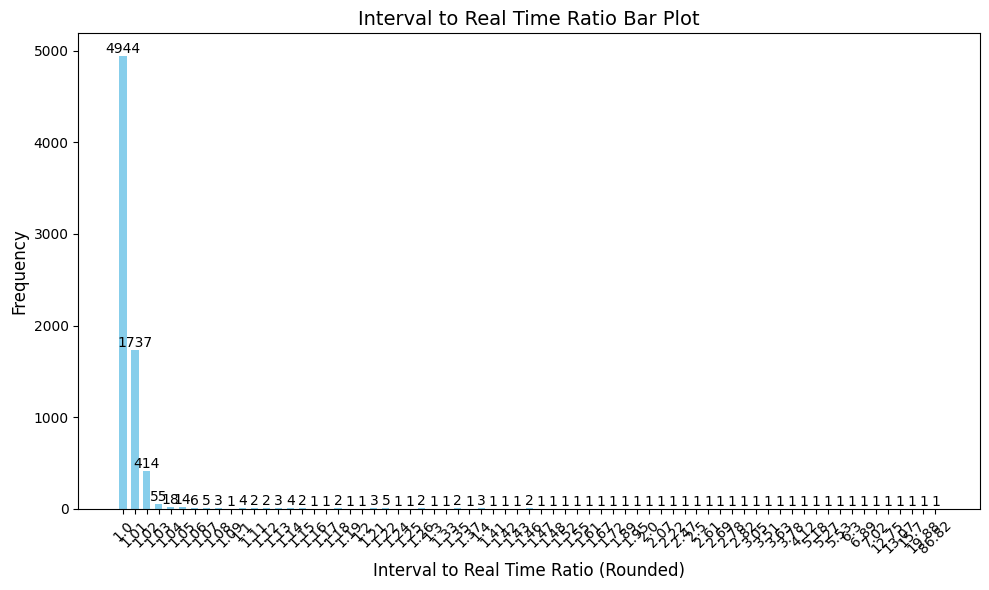

In [39]:
# 'interval_to_real_time_ratio' 열의 값들을 소수점 셋째 자리까지 반올림
data_last['rounded_ratio'] = data_last['interval_to_real_time_ratio'].round(2)

# 각 반올림된 값들의 빈도를 계산
ratio_counts = data_last['rounded_ratio'].value_counts().sort_index()

# 바 플롯 생성
plt.figure(figsize=(10, 6))
bars = plt.bar(ratio_counts.index.astype(str), ratio_counts.values, color='skyblue', width=0.6)

# 플롯 제목 및 레이블 설정
plt.title('Interval to Real Time Ratio Bar Plot', fontsize=14)
plt.xlabel('Interval to Real Time Ratio (Rounded)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# x축 레이블 회전 및 폰트 크기 조정
x_ticks = np.arange(0, 1.1, 0.1)
plt.xticks(rotation=45, fontsize=10)

# 각 막대 위에 빈도 수 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom', fontsize=10)

# 플롯 보여주기
plt.tight_layout()
plt.show()

## 여기서 아웃라이어들을 날리고(레벨1 인터벌이 비정상으로 높은애들) 1~100까지의 인터벌 자체를 real time으로 사용한다

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
data=pd.read_csv("../levelups_panel_20240717.csv", encoding="utf-8")

In [56]:
# level_to 컬럼의 값이 100을 넘는 행 제거
'''
data = data[data['level_to'] <= 100]
data = data[data['highest_level'] >= 100]
'''
data['binge'] = (data['first_session_level'] >= 50).astype(int)
# 각 player_slug별로 비율 계산
data['prev_interval'] = data.groupby('player_slug')['interval'].shift(1)
data['interval_ratio'] = data.apply(lambda row: row['interval'] / (row['prev_interval'] if pd.notnull(row['prev_interval']) else row['interval']), axis=1)

# level1 outlier 데이터들 제거
matching_rows = data[(data['level_to'] == 2) & (data['interval'] >= 1)]
# 해당 행의 player_slug 값 추출
player_slugs_to_remove = matching_rows['player_slug'].unique()
# player_slug가 일치하는 모든 행 삭제
data_filtered = data[~data['player_slug'].isin(player_slugs_to_remove)]
data_filtered.to_csv('levelups_panel_1004.csv',index=False,encoding='utf-8')

In [57]:
matching_rows['interval'].mean()

69.1527969828546

## 다시 Outlier 제거 및 Synthetic Control 진행

In [207]:
data=pd.read_csv("levelups_panel_1004.csv", encoding="utf-8")

In [208]:
data = data[data['level_to'] <= 100]
data = data[data['highest_level'] >= 100]
data['binge'] = (data['first_session_level'] >= 50).astype(int)

In [209]:
# interval_tot을 실제 기간으로 취급
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 interval의 누적합을 계산하여 'interval_until' 컬럼에 저장
data['interval_until'] = data.groupby('player_slug')['interval'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
data['realtime_tot'] = data.groupby('player_slug')['interval_until'].transform('last')


In [210]:
# level_to 별로 interval 값의 상위 5% (95th percentile) 계산
lev_top_percent = data.groupby('level_to')['interval'].quantile(0.975)

# apply를 사용하여 level_to별 threshold를 넘고 playtime_side가 0인 값들을 NaN으로 바꾸기
def replace_above_threshold(row):
    threshold = lev_top_percent[row['level_to']]
    # interval 값이 threshold보다 크고 playtime_side가 0인 경우 NaN으로 변경
    if row['interval'] > threshold: # and row['playtime_side'] == 0:
        return np.nan
    else:
        return row['interval']

# interval 컬럼에서 threshold를 넘고 playtime_side가 0인 값들은 NaN으로 변경
data['interval'] = data.apply(replace_above_threshold, axis=1)



In [211]:
#Remove odd ratio data
# 각 level_to 그룹별로 interval의 평균 계산
lev_avg = data.groupby('level_to')['interval'].median()
lev_avg_dict = lev_avg.to_dict()
lev_avg_dict

{2: 0.0102777777777777,
 3: 0.0052777777777777,
 4: 0.0127777777777777,
 5: 0.0161111111111111,
 6: 0.0218055555555555,
 7: 0.0233333333333333,
 8: 0.0233333333333333,
 9: 0.0297222222222222,
 10: 0.0347222222222222,
 11: 0.0444444444444444,
 12: 0.0286111111111111,
 13: 0.0316666666666666,
 14: 0.0291666666666666,
 15: 0.0297222222222222,
 16: 0.0152777777777777,
 17: 0.0272222222222222,
 18: 0.0247222222222222,
 19: 0.0033333333333333,
 20: 0.0136111111111111,
 21: 0.0177777777777777,
 22: 0.0058333333333333,
 23: 0.0113888888888888,
 24: 0.0122222222222222,
 25: 0.0038888888888888,
 26: 0.0030555555555555,
 27: 0.0102777777777777,
 28: 0.0108333333333333,
 29: 0.0116666666666666,
 30: 0.0130555555555555,
 31: 0.0083333333333333,
 32: 0.0127777777777777,
 33: 0.0144444444444444,
 34: 0.0134722222222222,
 35: 0.005,
 36: 0.0058333333333333,
 37: 0.0102777777777777,
 38: 0.0052777777777777,
 39: 0.0038888888888888,
 40: 0.0177777777777777,
 41: 0.0222222222222222,
 42: 0.02138888888888

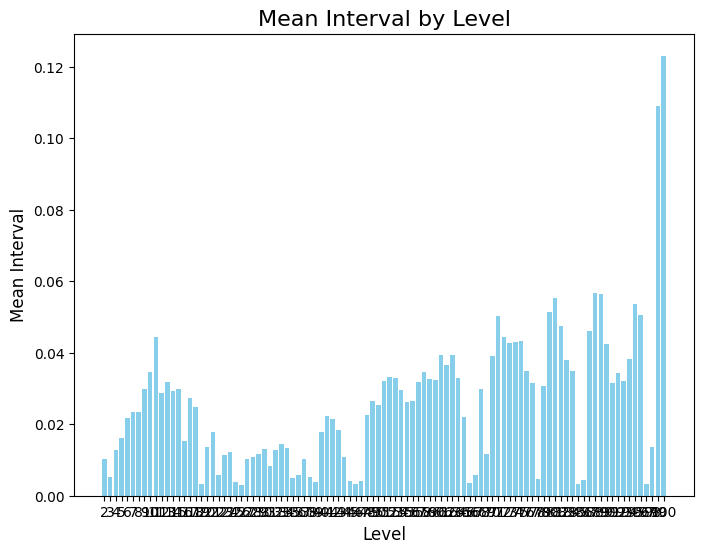

In [212]:
# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(lev_avg_dict.keys(), lev_avg_dict.values(), color='skyblue')

# 그래프 제목 및 축 레이블 설정
plt.title('Mean Interval by Level', fontsize=16)
plt.xlabel('Level', fontsize=12)
plt.ylabel('Mean Interval', fontsize=12)
plt.xticks(list(lev_avg_dict.keys()))

# 그래프 출력
plt.show()

In [213]:
data['interval'] = data.apply(
    lambda row: np.nan if (row['interval_ratio'] > 10 and row['interval'] > 50 * lev_avg_dict[row['level_to']]and row['playtime_side'] < 50 * lev_avg_dict[row['level_to']]) else row['interval'], 
    axis=1
)
# Step 2: player_slug가 동일하고 바로 다음 행에서 interval_ratio가 1인 데이터 처리

for i in range(len(data) - 1):
    if  data.iloc[i]['player_slug'] == data.iloc[i + 1]['player_slug'] and data.iloc[i + 1]['interval_ratio'] >= 0.1 and pd.isna(data.iloc[i]['interval']):
        data.iloc[i + 1, data.columns.get_loc('interval')] = np.nan


In [214]:
data['interval'].max()
max_interval_index = data['interval'].idxmax()
max_interval_row = data.loc[max_interval_index]
max_interval_row

player_slug            2021-12-19T06:05:28.461Z
character_slug                             shbj
first_session_level                           5
binger                                        0
total_purchase                              0.0
total_ad                                    1.0
highest_level                               154
status                                 complete
level_from                                   99
level_to                                    100
event_datetime              2021-12-22 22:18:20
death                                       0.0
ad_revival                                  0.0
ad_item                                     0.0
ad_total                                    0.0
purchase                                    0.0
event_datetime_prev         2021-12-22 02:11:26
interval                              20.115278
interval_cum                          79.214167
playtime_boss                               0.0
playtime_dungeon                        

In [194]:
data[data['player_slug']=='2021-12-20T05:47:52.309Z']['interval']

607310    0.008056
607311    0.005278
607312    0.018611
607313    0.011389
607314    0.025278
            ...   
607404    0.107222
607405    0.002778
607406    0.003056
607407    0.135556
607408    4.976667
Name: interval, Length: 99, dtype: float64

In [195]:
## 제거 전 평균과 제거 후 평균 비교
lev_avg_after = data.groupby('level_to')['interval'].mean()
lev_avg_after


level_to
2      0.013049
3      0.006726
4      0.014541
5      0.017104
6      0.024760
         ...   
96     0.094861
97     0.019727
98     0.049112
99     0.201630
100    0.254526
Name: interval, Length: 99, dtype: float64

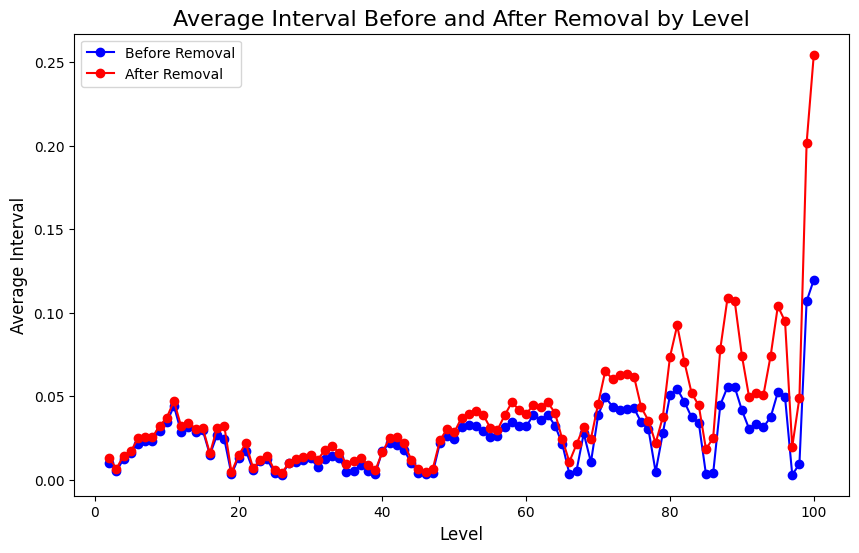

In [196]:
# 제거 후 평균 (이미 있는 lev_avg_after 값)
lev_avg_after = data.groupby('level_to')['interval'].mean()

# 그래프 그리기
plt.figure(figsize=(10, 6))

# 제거 전 평균
plt.plot(lev_avg.index, lev_avg.values, label='Before Removal', marker='o', color='blue')

# 제거 후 평균
plt.plot(lev_avg_after.index, lev_avg_after.values, label='After Removal', marker='o', color='red')

# 그래프 제목 및 레이블
plt.title('Average Interval Before and After Removal by Level', fontsize=16)
plt.xlabel('Level', fontsize=12)
plt.ylabel('Average Interval', fontsize=12)

# 범례 추가
plt.legend()

# 그래프 출력
plt.show()

In [181]:
data.to_csv('levelups_panel_1004_removed.csv',index=False,encoding='utf-8')

## Synthetic Control 진행

In [182]:
data=pd.read_csv("levelups_panel_1004_removed.csv", encoding="utf-8")

In [206]:
print(data['interval'].isna().sum())


21103


In [184]:
data

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_side,date_event,date_event_prev,same_date,date_interval,binge,prev_interval,interval_ratio,interval_until,realtime_tot
0,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,1,2,...,0.0,2021-11-01,2021-11-01,True,3.896389,1,NaN,1.000000,0.020556,3.726111
1,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,2,3,...,0.0,2021-11-01,2021-11-01,True,3.896389,1,0.020556,0.202703,0.024722,3.726111
2,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,3,4,...,0.0,2021-11-01,2021-11-01,True,3.896389,1,0.004167,1.466667,0.030833,3.726111
3,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,4,5,...,0.0,2021-11-01,2021-11-01,True,3.896389,1,0.006111,1.090909,0.037500,3.726111
4,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,5,6,...,0.0,2021-11-01,2021-11-01,True,3.896389,1,0.006667,2.958333,0.057222,3.726111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710815,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,95,96,...,0.0,2022-03-30,2022-03-30,True,3.398333,1,0.059444,0.098131,2.621667,2.818333
710816,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,96,97,...,0.0,2022-03-30,2022-03-30,True,3.398333,1,0.005833,0.523810,2.624722,2.818333
710817,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,97,98,...,0.0,2022-03-30,2022-03-30,True,3.398333,1,0.003056,15.545455,2.672222,2.818333
710818,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,98,99,...,0.0,2022-03-30,2022-03-30,True,3.398333,1,0.047500,1.520468,2.744444,2.818333
